# Spaceship Titanic
Predict which passengers are transported to an alternate dimension

## Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

### File and Data Field Descriptions
train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.

- PassengerId - Id for each passenger in the test set.
- Transported - The target. For each passenger, predict either True or False.

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [39]:
import numpy as np
import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

In [7]:
import pandas as pd

train_data = pd.read_csv('https://raw.githubusercontent.com/Andr3asAces/Kaggle-Titanic/main/data/train.csv')
test_data  = pd.read_csv('https://raw.githubusercontent.com/Andr3asAces/Kaggle-Titanic/main/data/test.csv')


### Define target and features

In [41]:
target_variable   = 'Transported'

feature_variables = list(train_data.columns)
feature_variables.remove('Transported')

## Training data

In [42]:
X = train_data[feature_variables]
y = train_data[target_variable]

In [43]:
X_train = X.copy()
y_train = y.copy()

## Plot target: Transported

<AxesSubplot:>

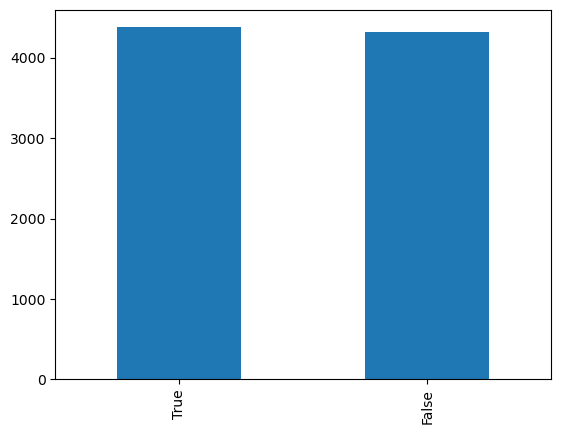

In [44]:
plot_df = y_train.value_counts()
plot_df.plot(kind="bar")

# Transformations

In [45]:
train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

## NA's

In [46]:
na_cols = X_train.isna().any(axis=0)
na_cols = na_cols.reset_index().rename(columns={'index':'variable','0':'isNA'})

In [47]:
na_rows = X_train[X_train.isna().any(axis=1)]

##### Passenger with same name are different

In [48]:
X_train['Name'].value_counts().shape[0]

8473

In [49]:
X_train[X_train['Name']=='Gollux Reedall']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
827,0881_01,Europa,False,D/32/S,TRAPPIST-1e,41.0,False,3103.0,3.0,0.0,31.0,26.0,Gollux Reedall
2852,3081_01,Europa,False,C/118/S,55 Cancri e,50.0,False,0.0,1547.0,0.0,1784.0,1.0,Gollux Reedall


In [50]:
X_train  = X.copy()
y_train  = y.copy()

## Which are categorical 

In [51]:
cat                         = list(X_train.columns[X_train.dtypes=='object'])

## To be dropped

In [52]:
variables_for_drop = ['PassengerId','Name']

In [53]:
X_train.drop( variables_for_drop,axis=1,inplace=True)

## To be label encoded

In [54]:
variables_for_label_encoder = ['Cabin','HomePlanet', 'Destination','VIP','CryoSleep']

In [55]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Iterate over each categorical column in X_train and transform the values
for col in X_train[variables_for_label_encoder]:
    X_train[col] = label_encoder.fit_transform(X_train[col])

In [56]:
X_train = X_train.astype(float)

In [57]:
X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,0.0,149.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2184.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0
2,1.0,0.0,1.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
3,1.0,0.0,1.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
4,0.0,0.0,2186.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0


## To be scaled

In [58]:
variables_for_std  = ['Age', 'RoomService','FoodCourt', 'ShoppingMall','Spa','VRDeck']

In [59]:
scaler         = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Impute NA with KNN

In [60]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Create an instance of the KNNImputer class
# You can adjust the number of neighbors (n_neighbors) as needed
imputer = KNNImputer(n_neighbors=5)

# Fit the imputer on your dataset and transform it to fill missing values
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)

# Now, if you want to inverse transform the scaled data back to its original scale
X_train_imputed = pd.DataFrame(scaler.inverse_transform(X_train_scaled_imputed),columns=X_train.columns)

In [61]:
import pickle

# Create a dictionary to store all the preprocessing objects
preprocessing_objects = {
    'label_encoder' : label_encoder,
    'scaler'        : scaler,
    'knn_imputer'   :imputer
}

# Save the preprocessing objects to a file
with open('preprocessing_objects.pkl', 'wb') as file:
    pickle.dump(preprocessing_objects, file)

In [62]:
### Check imputation worked
na_cols = X_train.isna().any(axis=0)
na_cols = na_cols.reset_index().rename(columns={'index':'variable','0':'isNA'})
na_rows = X_train.isna().any(axis=1)
X_train_imputed.index=X_train.index
pd.DataFrame(X_train_imputed)[na_rows]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0.0,1.0,4559.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,1.0,150.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
16,2.0,0.0,3564.0,0.0,27.0,0.0,1286.0,122.0,243.6,0.0,0.0
23,0.0,1.0,1407.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,1.0,1407.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8642,0.0,1.0,5277.0,2.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
8643,2.0,1.0,3313.0,2.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
8665,0.0,1.0,5271.0,2.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
8667,1.0,0.0,2117.0,2.0,29.0,0.0,0.0,2972.0,547.8,28.0,188.0


In [63]:
# Load the preprocessing objects from a file
with open('preprocessing_objects.pkl', 'rb') as file:
    preprocessing_objects = pickle.load(file)
    
# Extract the individual preprocessing objects from the dictionary
label_encoder  = preprocessing_objects['label_encoder']
scaler         = preprocessing_objects['scaler']
imputer        = preprocessing_objects['knn_imputer']

In [64]:
def transform(x):
    # Copy to avoid warnings & messing up global variables
    x = x.copy()
    
    # Drop
    x.drop(variables_for_drop,axis=1,inplace=True)
    
    # LabelEncoder
    # Iterate over each categorical column in X_train and transform the values
    for col in x[variables_for_label_encoder]:
        x[col] = label_encoder.fit_transform(x[col])
    
    # convert to floats
    x = x.astype(float)   
    
    # StandardScaler
    scaler         = StandardScaler()
    x_scaled       = scaler.fit_transform(x)
    
    return x_scaled

In [65]:
def knn_inputer(x_scaled):
    # KNN inputer
    imputer        = KNNImputer(n_neighbors=5)

    # Fit the imputer on your dataset and transform it to fill missing values
    x_scaled_imputed = imputer.fit_transform(x_scaled)

    return x_scaled_imputed

## Model training

In [66]:
#### For convinience I will set X_train as the version of the one Im using e.g. scaled or scaled and imputed
X_train_original = X_train.copy()
X_train          = X_train_scaled_imputed

In [67]:
y_train = np.array(y_train.astype(float)).ravel()

### Logistic regression - hyperparameter tuning

In [68]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create a logistic regression model
LR = LogisticRegression(solver='liblinear', max_iter=1000)

# Set up the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

# Create the grid search with cross-validation
grid_search = GridSearchCV(LR, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, np.ravel(y_train))

# Get the best parameters and score
best_params = grid_search.best_params_
best_score  = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

# Get the best estimator (model)
best_model = grid_search.best_estimator_

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

Best parameters: {'C': 0.001, 'fit_intercept': True, 'penalty': 'none', 'solver': 'newton-cg'}
Best score: 0.7791335443368839


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Sol

### Logistic regression fit

In [69]:
# Fit the model on the training data
LR = LogisticRegression(**best_params)
LR.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


LogisticRegression(C=0.001, penalty='none', solver='newton-cg')

## XGB hyperparameter tuning

In [70]:
### This will take more time
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0.5, 1, 1.5],
    'n_estimators': [50, 200, 150],
}

In [71]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'learning_rate': [0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [50, 250, 500],
}

# Create a base XGBClassifier model
xgb_model = XGBClassifier(
    base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.300000012,
    max_delta_step=0,
    max_depth=6,
    min_child_weight=1,
    missing=None,
    n_estimators=100,
    n_jobs=0,
    objective='binary:logistic',
    random_state=0,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    subsample=1,
    tree_method='exact',
    use_label_encoder=False,
    validate_parameters=1,
    verbosity=None
)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=2
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

Best hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 50}


## XGB boost best fit

In [72]:
import xgboost as xgb

# Instantiate a new XGBClassifier with the best parameters
XGB = XGBClassifier(**best_params)

# Fit the model to the training data
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## Random Forest - hyperparameter tuning

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}


In [73]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Prepare your data
# X_train, y_train = ...

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100,500],
    'max_depth': [None, 3, 4],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True],
}

# Create a base RandomForestClassifier model
rf_model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=2
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END ........gamma=0, learning_rate=0.1, n_estimators=50; total time=   6.6s
[CV] END ........gamma=0, learning_rate=0.1, n_estimators=50; total time=   0.6s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=250; total time=   2.9s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=250; total time=   2.8s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=250; total time=   2.8s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=500; total time=   5.6s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=500; total time=   6.1s
[CV] END ........gamma=0, learning_rate=0.2, n_estimators=50; total time=   0.6s
[CV] END ........gamma=0, learning_rate=0.2, n_estimators=50; total time=   0.6s
[CV] END ........gamma=0, learning_rate=0.2, n_estimators=50; total time=   0.6s
[CV] END ........gamma=0, learning_rate=0.2, n_estimators=50; total time=   0.6s
[CV] END ........gamma=0, learning_rate=0.2, n_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 1440, in predict
    iteration_range=iteration_range,
  File "/opt/conda/lib/python3.7/site-packages

[CV] END ........gamma=0, learning_rate=0.1, n_estimators=50; total time=   6.6s
[CV] END ........gamma=0, learning_rate=0.1, n_estimators=50; total time=   0.6s
[CV] END ........gamma=0, learning_rate=0.1, n_estimators=50; total time=   0.6s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=250; total time=   2.9s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=250; total time=   2.8s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=500; total time=   5.5s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=500; total time=   6.2s
[CV] END .......gamma=0, learning_rate=0.1, n_estimators=500; total time=   5.5s
[CV] END .......gamma=0, learning_rate=0.2, n_estimators=250; total time=   2.9s
[CV] END .......gamma=0, learning_rate=0.2, n_estimators=250; total time=   2.7s
[CV] END .......gamma=0, learning_rate=0.2, n_estimators=500; total time=   5.4s
[CV] END .......gamma=0, learning_rate=0.2, n_estimators=500; total time=   5.5s
[CV] END .......gamma=0, lea

## Random forest best fit

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create the Random Forest classifier
RF = RandomForestClassifier(**best_params)

# Fit the model on the training data
RF.fit(X_train_scaled_imputed, y_train)


RandomForestClassifier(max_features='log2', min_samples_split=4)

# Ensemble model - majority vote

In [75]:
from sklearn.ensemble import VotingClassifier
# Instantiate the ensemble model with the best XGB, RF, and LR models
ensemble_model = VotingClassifier(
    estimators=[('xgb', XGB), ('rf', RF), ('lr', LR)],
    voting='hard',  
    n_jobs=-1
)

### fit the ensemble model 

In [76]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.1, max_bin=256,
                                            max_ca...
                                            max_delta_step=0, max_depth=6,
                                        

### predict using the ensemble model

In [80]:
X_test        = test_data  
X_test_scaled = transform(X_test)
X_test_scaled_imputed = knn_inputer(X_test_scaled)

In [81]:
y_pred_ensemble = ensemble_model.predict(X_test_scaled_imputed) 

### Final Submission

In [82]:
# Get the predictions for testdata
n_predictions = (y_pred_ensemble > 0.5).astype(bool) # y_pred_ensemble is 0 or 1 unless you use 'soft' voting
output = pd.DataFrame({'PassengerId': X_test['PassengerId'],
                       'Transported': n_predictions})

output.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [83]:
sample_submission_df = pd.read_csv('https://raw.githubusercontent.com/Andr3asAces/Kaggle-Titanic/main/data/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
#sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"



[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=3, max_features=log2, mi

![titanic](https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg)